In [3]:
#load libraries
import pandas as pd
import os
import numpy as np
import datetime as dt
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
#from pmdarima import auto_arima   

In [26]:
#load folder-the actual data were given in 17 separate excel files
files = os.listdir('dataLoad')
files

['Cons_Report_122018.xlsx',
 'Cons_Report_052019.xlsx',
 'Cons_Report_042019.xlsx',
 'Cons_Report_052018.xlsx',
 'Cons_Report_042018.xlsx',
 'Cons_Report_022018.xlsx',
 'Cons_Report_032018.xlsx',
 'Cons_Report_082018.xlsx',
 'Cons_Report_092018.xlsx',
 'Cons_Report_022019.xlsx',
 'Cons_Report_032019.xlsx',
 'Cons_Report_062018.xlsx',
 'Cons_Report_072018.xlsx',
 'Load Demand_Forecast.xlsx',
 'Cons_Report_112018.xlsx',
 'Cons_Report_102018.xlsx',
 'Cons_Report_012019.xlsx',
 'Cons_Report_012018.xlsx']

In [9]:
#list of files to loop-only xlsx
files_xls = [f for f in files if 'Cons_Report' in f]
files_xls

['Cons_Report_122018.xlsx',
 'Cons_Report_052019.xlsx',
 'Cons_Report_042019.xlsx',
 'Cons_Report_052018.xlsx',
 'Cons_Report_042018.xlsx',
 'Cons_Report_022018.xlsx',
 'Cons_Report_032018.xlsx',
 'Cons_Report_082018.xlsx',
 'Cons_Report_092018.xlsx',
 'Cons_Report_022019.xlsx',
 'Cons_Report_032019.xlsx',
 'Cons_Report_062018.xlsx',
 'Cons_Report_072018.xlsx',
 'Cons_Report_112018.xlsx',
 'Cons_Report_102018.xlsx',
 'Cons_Report_012019.xlsx',
 'Cons_Report_012018.xlsx']

In [10]:
#create one datafram from all the excel files
actual = pd.DataFrame()
for f in files_xls:
    data = pd.read_excel('dataLoad/' + f)
    actual=actual.append(data, ignore_index=True)

In [11]:
#get column names
actual.columns

Index(['deliveryDay', 'Hour_EET', 'Gen_Aux', 'HV', 'Pump', 'TEL_MV', 'Network',
       'Total'],
      dtype='object')

In [27]:
#rename columns
actual.columns=['Date','Hour','Gen_Aux', 'HV', 'Pump', 'TEL_MV', 'Network','ActualTotal']
actual.head()

,Date,Hour,Gen_Aux,HV,Pump,TEL_MV,Network,ActualTotal
0,2018-12-01,1,33.006141,934.808670,0.0,954.722055,4595.257242,5563.072052
1,2018-12-01,2,43.988918,959.233194,0.0,931.364922,4063.666352,5066.888464
2,2018-12-01,3,46.329801,970.324019,0.0,910.726163,3938.994044,4955.647864
3,2018-12-01,4,36.405052,995.836951,0.0,901.447118,3755.516237,4787.758241
4,2018-12-01,5,36.149028,991.074298,0.0,896.550351,3646.883398,4674.106724


- Date,Hour=Ημερομηνια Αναφοράς
- Gen_Aux=φορτιο παραγωγής μονάδων
- HV=Φορτίο Υψηλής τάσης
- Pump=Αναμενω ενημέρωση
- Network (ΜΤ+ΧΤ)= μας δίνει το συνολικό actual φορτίο
- TEL_MV=Φορτιο της τηλεμετρουμενης μεσης τασης.
- ΧΤ= Η στηλη που δημιουργώ αφαιρώντας την τηλεμετρουμενη ΜΤ από το Network και βρίσκω την actual total XT που θέλω να προβλεψω.
- ActualTotal= Το αθροισμα των Network+HV+Gen_Aux+Pump που μας δίνει το συνολικό φορτίο. Αυτό θα το χρησιμοποιήσω αργότερα για να βρω τι ποσοστό είναι η ΧΤ σε σχέση με το ActualTotal.



In [12]:
#load excel with forecast of the current program
forecast=pd.read_excel("dataLoad/Load Demand_Forecast.xlsx")

In [13]:
forecast.head()

,Year,Month,Weekday,Holiday,Date,1,2,3,4,5,...,21,22,23,24,Sum,Avrg,Max,Min,Δ vs D-1,Δ vs D-7
0,2018,1,1,1,2018-01-01,5315.0,4963.0,4838.0,4515.0,4280.0,...,6198.0,6021.0,5756.0,5513.0,127512.0,5313.000000,6237.0,4182.0,-0.112966,-0.077077
1,2018,1,2,0,2018-01-02,5023.0,4612.0,4573.0,4389.0,4250.0,...,6831.0,6517.0,6106.0,5717.0,135940.0,5664.166667,6927.0,4250.0,0.066096,-0.011101
2,2018,1,3,0,2018-01-03,5211.0,4761.0,4721.0,4547.0,4438.0,...,7409.0,6949.0,6411.0,5962.0,146200.0,6091.666667,7554.0,4438.0,0.075474,-0.001666
3,2018,1,4,0,2018-01-04,5307.0,4788.0,4721.0,4525.0,4427.0,...,7483.0,7014.0,6476.0,6038.0,149234.0,6218.083333,7649.0,4427.0,0.020752,0.020194
4,2018,1,5,0,2018-01-05,5420.0,4932.0,4865.0,4718.0,4621.0,...,7453.0,6984.0,6455.0,6037.0,149052.0,6210.500000,7550.0,4621.0,-0.001220,0.010892


In [21]:
#data manipulation to create new dataframe
forecast2=forecast[['Weekday',  'Holiday','Date', 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]]
prediction = pd.melt(forecast2, id_vars=["Weekday", "Holiday", "Date"])
prediction.head(10)

,Weekday,Holiday,Date,variable,value
0,1,1,2018-01-01,1,5315.0
1,2,0,2018-01-02,1,5023.0
2,3,0,2018-01-03,1,5211.0
3,4,0,2018-01-04,1,5307.0
4,5,0,2018-01-05,1,5420.0
5,6,1,2018-01-06,1,5430.0
6,7,0,2018-01-07,1,5348.0
7,1,0,2018-01-08,1,5170.0
8,2,0,2018-01-09,1,5343.0
9,3,0,2018-01-10,1,5304.0


In [22]:
prediction.tail(10)

,Weekday,Holiday,Date,variable,value
12374,3,0,2019-05-22,24,5066.0
12375,4,0,2019-05-23,24,5126.0
12376,5,0,2019-05-24,24,5092.0
12377,6,0,2019-05-25,24,4961.0
12378,7,0,2019-05-26,24,4802.0
12379,1,0,2019-05-27,24,5093.0
12380,2,0,2019-05-28,24,5088.0
12381,3,0,2019-05-29,24,5111.0
12382,4,0,2019-05-30,24,5185.0
12383,5,0,2019-05-31,24,5105.0


In [23]:
#rename columns
prediction.columns=[ 'Weekday', 'Holiday', 'Date', 'Hour', 'ForecastTotalLoad' ]
prediction.head(10)

,Weekday,Holiday,Date,Hour,ForecastTotalLoad
0,1,1,2018-01-01,1,5315.0
1,2,0,2018-01-02,1,5023.0
2,3,0,2018-01-03,1,5211.0
3,4,0,2018-01-04,1,5307.0
4,5,0,2018-01-05,1,5420.0
5,6,1,2018-01-06,1,5430.0
6,7,0,2018-01-07,1,5348.0
7,1,0,2018-01-08,1,5170.0
8,2,0,2018-01-09,1,5343.0
9,3,0,2018-01-10,1,5304.0


- ForecastTotalLoad είναι η προβλεψη για το συνολικό actual φορτίο όπως την κάνουν τωρα και πρέπει να συγκριθεί με την αντίστοιχη τιμή πιο πανω του ActualTotal.

In [31]:
actual.set_index(['Date', 'Hour']).head()

Gen_Aux          HV  Pump      TEL_MV      Network  \
Date       Hour                                                         
2018-12-01 1     33.006141  934.808670   0.0  954.722055  4595.257242   
           2     43.988918  959.233194   0.0  931.364922  4063.666352   
           3     46.329801  970.324019   0.0  910.726163  3938.994044   
           4     36.405052  995.836951   0.0  901.447118  3755.516237   
           5     36.149028  991.074298   0.0  896.550351  3646.883398   

                 ActualTotal  
Date       Hour               
2018-12-01 1     5563.072052  
           2     5066.888464  
           3     4955.647864  
           4     4787.758241  
           5     4674.106724

In [30]:
prediction.set_index(['Date', 'Hour']).head()

,,Weekday,Holiday,ForecastTotalLoad
Date,Hour,,,
2018-01-01,1,1,1,5315.0
2018-01-02,1,2,0,5023.0
2018-01-03,1,3,0,5211.0
2018-01-04,1,4,0,5307.0
2018-01-05,1,5,0,5420.0


* Join the two dataframes.

In [128]:
final = pd.merge(prediction, actual, on=['Date', 'Hour'])
final.head()

,Weekday,Holiday,Date,Hour,ForecastTotalLoad,Gen_Aux,HV,Pump,TEL_MV,Network,ActualTotal
0,1,1,2018-01-01,1,5315.0,34.418093,757.020147,0.000,596.563993,4529.773678,5321.211918
1,2,0,2018-01-02,1,5023.0,45.218816,751.513843,0.000,610.814364,4101.718326,4898.450985
2,3,0,2018-01-03,1,5211.0,37.042898,904.679508,0.000,800.563658,4283.392261,5225.114667
3,4,0,2018-01-04,1,5307.0,35.636497,918.203986,0.000,853.288369,4450.591164,5404.431647
4,5,0,2018-01-05,1,5420.0,37.712368,961.116481,23.108,866.047536,4617.594242,5639.531090


In [129]:
final['Timestamp'] = final['Date'] + pd.to_timedelta(final['Hour'], unit='h')
final.head()

,Weekday,Holiday,Date,Hour,ForecastTotalLoad,Gen_Aux,HV,Pump,TEL_MV,Network,ActualTotal,Timestamp
0,1,1,2018-01-01,1,5315.0,34.418093,757.020147,0.000,596.563993,4529.773678,5321.211918,2018-01-01 01:00:00
1,2,0,2018-01-02,1,5023.0,45.218816,751.513843,0.000,610.814364,4101.718326,4898.450985,2018-01-02 01:00:00
2,3,0,2018-01-03,1,5211.0,37.042898,904.679508,0.000,800.563658,4283.392261,5225.114667,2018-01-03 01:00:00
3,4,0,2018-01-04,1,5307.0,35.636497,918.203986,0.000,853.288369,4450.591164,5404.431647,2018-01-04 01:00:00
4,5,0,2018-01-05,1,5420.0,37.712368,961.116481,23.108,866.047536,4617.594242,5639.531090,2018-01-05 01:00:00


In [130]:
final.sort_values('Timestamp', inplace=True)
final.head()

,Weekday,Holiday,Date,Hour,ForecastTotalLoad,Gen_Aux,HV,Pump,TEL_MV,Network,ActualTotal,Timestamp
0,1,1,2018-01-01,1,5315.0,34.418093,757.020147,0.000,596.563993,4529.773678,5321.211918,2018-01-01 01:00:00
516,1,1,2018-01-01,2,4963.0,40.928810,760.024989,0.000,589.266551,4205.128845,5006.082645,2018-01-01 02:00:00
1032,1,1,2018-01-01,3,4838.0,39.286246,750.624526,0.000,585.334471,4116.742544,4906.653316,2018-01-01 03:00:00
1548,1,1,2018-01-01,4,4515.0,38.678094,756.567856,0.120,582.210175,3833.136857,4628.502808,2018-01-01 04:00:00
2064,1,1,2018-01-01,5,4280.0,37.498531,731.949138,130.176,581.251131,3608.455842,4508.079510,2018-01-01 05:00:00


In [131]:
final.tail()

,Weekday,Holiday,Date,Hour,ForecastTotalLoad,Gen_Aux,HV,Pump,TEL_MV,Network,ActualTotal,Timestamp
10319,5,0,2019-05-31,20,5572.0,33.211102,876.113437,0.0,1397.706018,4901.567117,5810.891656,2019-05-31 20:00:00
10835,5,0,2019-05-31,21,5740.0,32.731239,890.764508,0.0,1355.517513,5000.305264,5923.801011,2019-05-31 21:00:00
11351,5,0,2019-05-31,22,5915.0,32.180987,861.846122,0.0,1268.293778,5123.894570,6017.921678,2019-05-31 22:00:00
11867,5,0,2019-05-31,23,5506.0,33.389455,856.024205,0.0,1152.098123,4680.730403,5570.144063,2019-05-31 23:00:00
12381,5,0,2019-05-31,24,5105.0,35.753307,964.764549,0.0,1092.041595,4227.795192,5228.313048,2019-06-01 00:00:00


In [132]:
#εχω ενα ΝΑ το οποίο οφείλεται στην αλλαγή της ωρας 25/3, εχω μιλήσει με τον αναλυτη εδω για το πως πρεπει να το διαχειριστω
#προς το παρον βαζω την τιμη της προηγούμενης ώρας manually
final=final.fillna(4.432)

In [133]:
#check for null values-Clean
final.isnull().values.any()

False

In [134]:
#create the column of interest
final['XT'] = final['Network'] - final['TEL_MV']
#finalize dataset and set frequency
final=final[['Timestamp','XT','Weekday','Holiday']]
final.sort_values('Timestamp', inplace=True)
final.set_index('Timestamp', inplace=True)

* Check the index for the frequency (should be hourly).

In [138]:
final.index

DatetimeIndex(['2018-01-01 01:00:00', '2018-01-01 02:00:00',
               '2018-01-01 03:00:00', '2018-01-01 04:00:00',
               '2018-01-01 05:00:00', '2018-01-01 06:00:00',
               '2018-01-01 07:00:00', '2018-01-01 08:00:00',
               '2018-01-01 09:00:00', '2018-01-01 10:00:00',
               ...
               '2019-05-31 15:00:00', '2019-05-31 16:00:00',
               '2019-05-31 17:00:00', '2019-05-31 18:00:00',
               '2019-05-31 19:00:00', '2019-05-31 20:00:00',
               '2019-05-31 21:00:00', '2019-05-31 22:00:00',
               '2019-05-31 23:00:00', '2019-06-01 00:00:00'],
              dtype='datetime64[ns]', name='Timestamp', length=12382, freq=None)

* The `None` reported value indicates that there might be missing values.

In [141]:
pd.date_range(final.index.min(), final.index.max(), freq='H').difference(final.index)

DatetimeIndex(['2018-03-26', '2019-04-01'], dtype='datetime64[ns]', freq=None)

* Let's check what happens around the first date.

In [137]:
final.loc['2018-03-25':'2018-03-26']

,XT,Weekday,Holiday
Timestamp,,,
2018-03-25 00:00:00,3652.898195,6,0
2018-03-25 01:00:00,3147.824162,7,1
2018-03-25 02:00:00,2740.862797,7,1
2018-03-25 03:00:00,2654.360886,7,1
2018-03-25 04:00:00,2507.887529,7,1
2018-03-25 05:00:00,2440.072651,7,1
2018-03-25 06:00:00,2515.380769,7,1
2018-03-25 07:00:00,2612.671803,7,1
2018-03-25 08:00:00,2930.827226,7,1


* There is a missing from March 25 to March 26, 2018.

* Let's also check what is happening with the second date.

In [146]:
final.loc['2019-03-31':'2019-04-01']

,XT,Weekday,Holiday
Timestamp,,,
2019-03-31 00:00:00,3800.919862,6,0
2019-03-31 01:00:00,3301.206709,7,0
2019-03-31 02:00:00,2873.602290,7,0
2019-03-31 03:00:00,2747.037509,7,0
2019-03-31 04:00:00,2588.609454,7,0
2019-03-31 05:00:00,2508.161442,7,0
2019-03-31 06:00:00,2584.451302,7,0
2019-03-31 07:00:00,2782.655535,7,0
2019-03-31 08:00:00,3116.754635,7,0


* Same story, an hour was skipped between March 31 and April 1, 2019.

* We'll fix the issue by using the previous value.

In [148]:
final = final.asfreq(freq='H', method='pad')
final.index

DatetimeIndex(['2018-01-01 01:00:00', '2018-01-01 02:00:00',
               '2018-01-01 03:00:00', '2018-01-01 04:00:00',
               '2018-01-01 05:00:00', '2018-01-01 06:00:00',
               '2018-01-01 07:00:00', '2018-01-01 08:00:00',
               '2018-01-01 09:00:00', '2018-01-01 10:00:00',
               ...
               '2019-05-31 15:00:00', '2019-05-31 16:00:00',
               '2019-05-31 17:00:00', '2019-05-31 18:00:00',
               '2019-05-31 19:00:00', '2019-05-31 20:00:00',
               '2019-05-31 21:00:00', '2019-05-31 22:00:00',
               '2019-05-31 23:00:00', '2019-06-01 00:00:00'],
              dtype='datetime64[ns]', name='Timestamp', length=12384, freq='H')

In [149]:
#check the finalized dataset
final

,XT,Weekday,Holiday
Timestamp,,,
2018-01-01 01:00:00,3933.209685,1,1
2018-01-01 02:00:00,3615.862294,1,1
2018-01-01 03:00:00,3531.408073,1,1
2018-01-01 04:00:00,3250.926682,1,1
2018-01-01 05:00:00,3027.204711,1,1
2018-01-01 06:00:00,2934.418572,1,1
2018-01-01 07:00:00,2990.903843,1,1
2018-01-01 08:00:00,3048.662534,1,1
2018-01-01 09:00:00,3189.215049,1,1


In [150]:
#Here is going to be the EDA part-just some quick insights

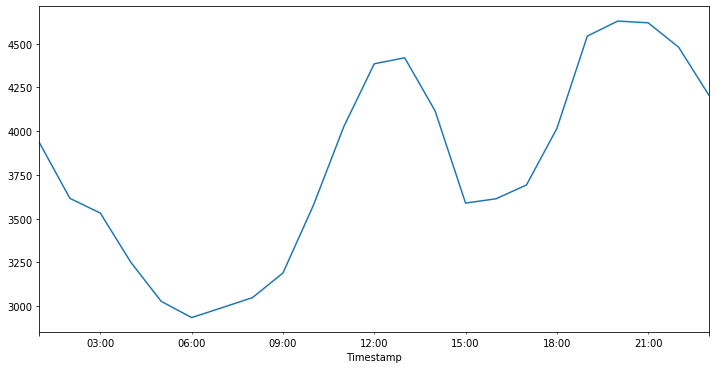

In [151]:
final['XT'].iloc[:23].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

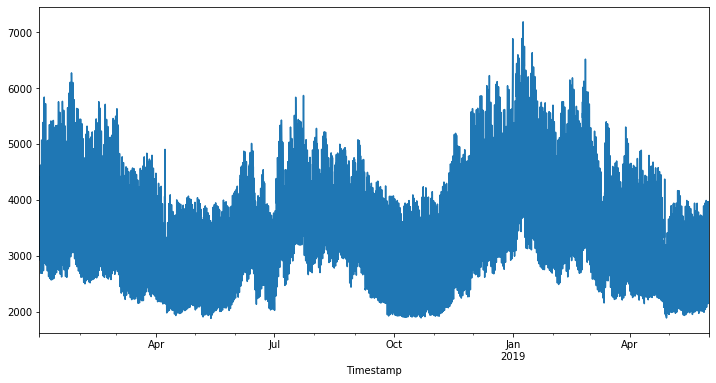

In [152]:
#αυτα τα 2 outliers ειναι οταν αλλαζει η ωρα τον Μαρτιο
final['XT'].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

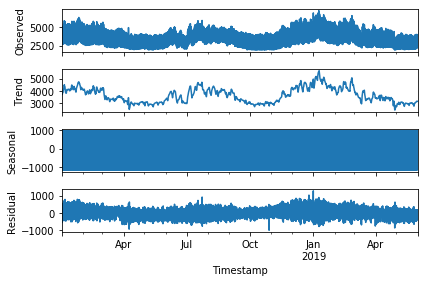

In [153]:
result = seasonal_decompose(final['XT'])
result.plot();

In [154]:
#create ad-fuller test function
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [155]:
adf_test(final['XT'])

Augmented Dickey-Fuller Test: 
ADF test statistic         -3.934115
p-value                     0.001798
# lags used                41.000000
# observations          12342.000000
critical value (1%)        -3.430880
critical value (5%)        -2.861774
critical value (10%)       -2.566895
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [28]:
# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(final['XT'].loc['2019-01-01':'2019-05-01'],seasonal=True,m=24).summary()

C:\Users\ntarz\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
C:\Users\ntarz\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
C:\Users\ntarz\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:726: RuntimeWarning: divide by zero encountered in double_scalars
  (1 - np.sum(tra

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 2904
Model:             SARIMAX(1, 1, 1)x(2, 0, 0, 24)   Log Likelihood              -18677.594
Date:                            Fri, 12 Jul 2019   AIC                          37367.188
Time:                                    15:42:09   BIC                          37403.029
Sample:                                         0   HQIC                         37380.102
                                           - 2904                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -7.075e-05      0.004     -0.020      0.984      -0.007       0.007
ar.L1          0.9975      0.060     16.507      0.000       0.879       1.116
ma.L1         -0.9992      0.063    -15.929      0.000      -1.122      -0.876
ar.S.L24       0.5501      0.002    231.330      0.000       0.545       0.555
ar.S.L48       0.3748      0.003    116.922      0.000       0.369       0.381
sigma2       2.24e+04     92.745    241.474      0.000    2.22e+04    2.26e+04
===================================================================================
Ljung-Box (Q):                      363.54   Jarque-Bera (JB):           6826865.50
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.22   Skew:                             0.63
Prob(H) (two-sided):                  0.00   Kurtosis:                       240.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
#use the period used for training
df1=final.loc['2019-03-01':'2019-05-01']

In [30]:
#train/test split
train = df1.iloc[:1440]
test = df1.iloc[1440:]

In [39]:
#run model
model = SARIMAX(train['XT'],exog=train[['Holiday']],order=(1,1,1),seasonal_order=(2,0,0,24),enforce_invertibility=False)
results = model.fit()
results.summary()

C:\Users\ntarz\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                 XT   No. Observations:                 1440
Model:             SARIMAX(1, 1, 1)x(2, 0, 0, 24)   Log Likelihood               -9491.364
Date:                            Fri, 12 Jul 2019   AIC                          18994.728
Time:                                    15:49:19   BIC                          19026.358
Sample:                                03-01-2019   HQIC                         19006.536
                                     - 04-29-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Holiday      -50.7683     69.743     -0.728      0.467    -187.462      85.925
ar.L1          0.8369      0.005    156.424      0.000       0.826       0.847
ma.L1         -0.9975      0.005   -216.951      0.000      -1.007      -0.989
ar.S.L24       0.5002      0.004    119.822      0.000       0.492       0.508
ar.S.L48       0.3834      0.005     72.559      0.000       0.373       0.394
sigma2      3.112e+04    144.697    215.074      0.000    3.08e+04    3.14e+04
===================================================================================
Ljung-Box (Q):                      136.02   Jarque-Bera (JB):           1960615.47
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.74   Skew:                            -1.73
Prob(H) (two-sided):                  0.00   Kurtosis:                       183.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [40]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
exog_forecast = test[['Holiday']]  # requires two brackets to yield a shape of (35,1)
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX(1,1,1)(2,0,0,24) Predictions')

C:\Users\ntarz\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


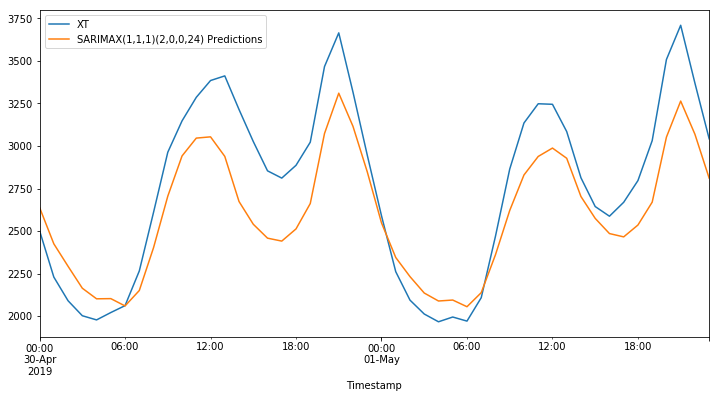

In [41]:
# Plot predictions against known values
ax = test['XT'].plot(legend=True,figsize=(12,6))
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)